In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from math import sqrt

from tracking.kalman import kalman_pv
from tracking.util import to_df, colorscale

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Kalman gain with varying sampling interval

We have already analyzed how Kalman Gain converges to a specific value when tracking a single target with constant measurement noise and constant sampling rate? What will the convergence of Kalman Gain look like when the sampling interval is not constant?

In [5]:
def simulate_kalman_1d(Q_intensity, R, time):
    P = R

    trace = []
    for time, dt in zip(time[1:], np.diff(np.array(time))):
        Q = dt**3/3 * Q_intensity
        P = P + Q
        K = P/(P+R)
        P = (1-K)*P
        trace.append((Q_intensity, R, time, dt, K, P))
    return to_df(np.array(trace), columns=['Q', 'R', 't', 'dt', 'K', 'P']).melt(id_vars=['dt', 't', 'Q', 'R'], var_name='parameter')

## Low variation of dt

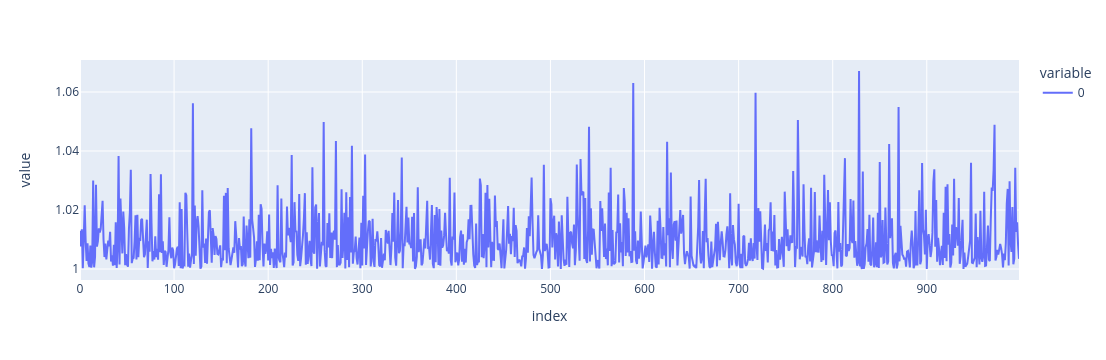

In [6]:
time = np.cumsum(1+np.random.exponential(.01, size=1000))
ex.line(np.diff(time))

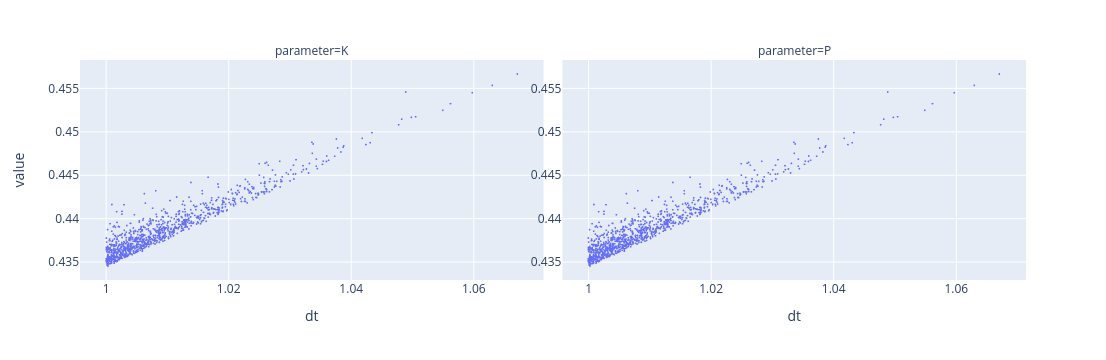

In [7]:
trace = simulate_kalman_1d(1, 1, time).query("t > 10")
fig = ex.scatter(trace, x='dt', y='value', facet_col='parameter')
fig.update_traces(marker_size=2)
fig.update_yaxes(matches=None, showticklabels=True)
fig

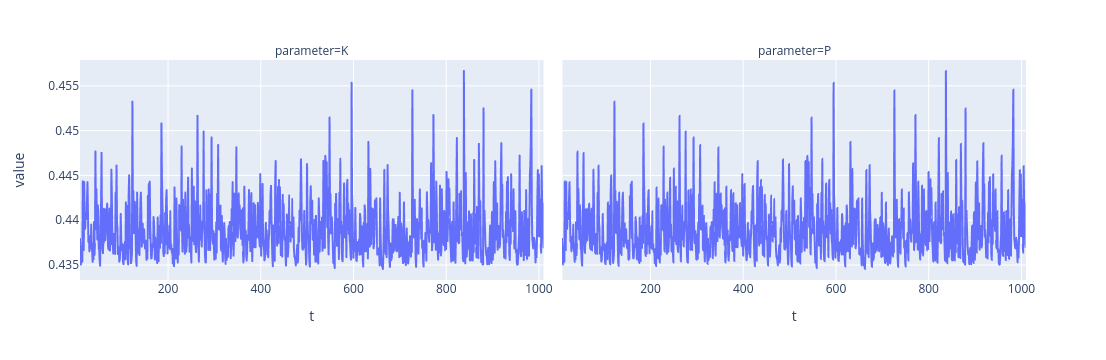

In [8]:
ex.line(trace, x='t', y='value', facet_col='parameter')

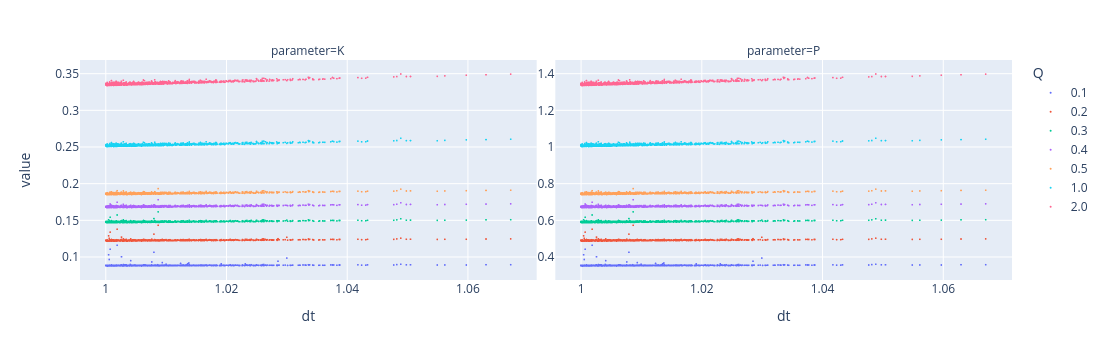

In [9]:
trace = []
for Q in [.1, .2, .3, .4, .5, 1, 2]:
    trace.append(simulate_kalman_1d(Q, 4, time).query("t > 10"))

trace = pd.concat(trace)
trace.Q = trace.Q.astype("category")

fig = ex.scatter(trace, x='dt', y='value', color='Q', facet_col='parameter')
fig.update_traces(marker_size=2)
fig.update_yaxes(matches=None, showticklabels=True)
fig

## High variation of dt

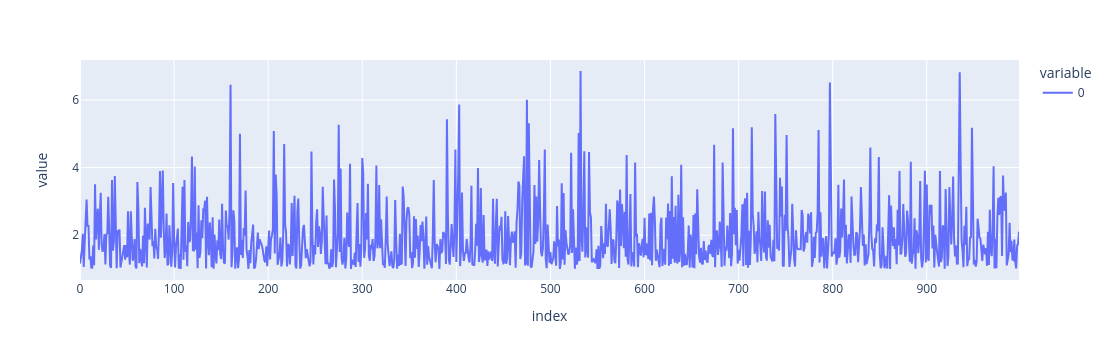

In [15]:
time = np.cumsum(1+np.random.exponential(1, size=1000))
ex.line(np.diff(time))

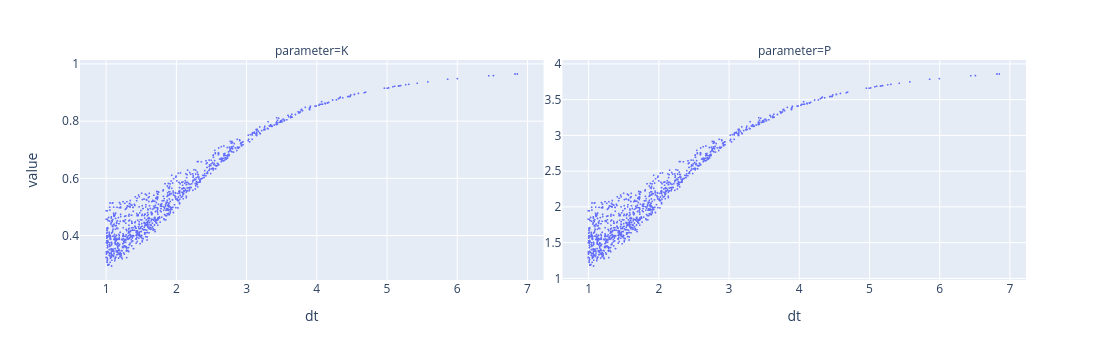

In [16]:
trace = simulate_kalman_1d(1, 4, time).query("t > 10")
fig = ex.scatter(trace, x='dt', y='value', facet_col='parameter')
fig.update_traces(marker_size=2)
fig.update_yaxes(matches=None, showticklabels=True)
fig

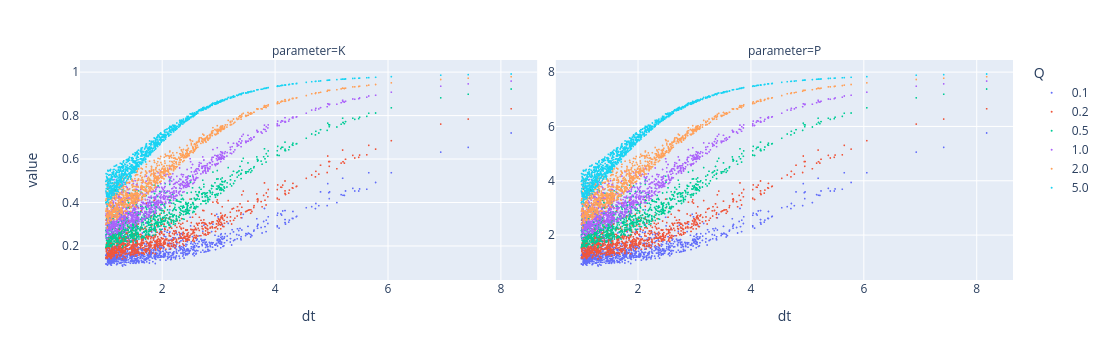

In [12]:
trace = []
for Q in [.1, .2, .5, 1, 2, 5]:
    trace.append(simulate_kalman_1d(Q, 8, time).query("t > 10"))

trace = pd.concat(trace)
trace.Q = trace.Q.astype("category")

fig = ex.scatter(trace, x='dt', y='value', facet_col='parameter', color='Q')
fig.update_traces(marker_size=2)
fig.update_yaxes(matches=None, showticklabels=True)
fig

The larger $dt$, the closer Kalman gain gets to 1. The reason is straightforward: the longer the interval between two samples, the larger the process noise gets and the smaller in comparison it is to the measurement noise.

Moreover, any given value of $dt$ (up to some rounding error) is sampled multiple times, each time with a different state of the Kalman Filter, and a different value of its covariance estimate. Therefore, the resulting value of Kalman gain is also different - which shows in the width of each "band" of colored points.

## Kalman filter in 2D: position and velocity

In [13]:
def simulate_kalman_2d(Q_intensity, R, time):
    H = np.array([[1, 0]])
    P = np.array([[R, 0], [0, R]])
    R = np.eye(1) * R

    trace = []
    for dt in np.diff(np.array(time)):
        # "Estimation with Applications to Tracking and Navigation", p. 270
        # process noise for the continuous white noise acceleration (CWNA)
        # model; velocity changes at discrete time intervals by white-noise
        # derived values
        dt3 = dt**3 / 3
        dt2 = dt**2 / 2
        Q = np.array([[dt3, dt2], [dt2, dt]]) * Q_intensity

        # state transition matrix
        F = np.array([[1, dt], [0, 1]])

        # Kalman update as it pertains only to covariance and Kalman gain
        # (state is not a value of interest)
        P = F @ P @ F.T + Q
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
    
        P = P - K @ S @ K.T

        trace.append((P, K))
    
    return tuple([np.array(x) for x in zip(*trace)])

In [14]:
time = np.cumsum(np.abs(np.random.normal(1, .1, size=100)))
simulate_kalman_2d(1, 1, time)

(array([[[0.67997389, 0.43414156],
         [0.43414156, 1.33800854]],
 
        [[0.72817684, 0.53900691],
         [0.53900691, 1.14203367]],
 
        [[0.76159409, 0.50973108],
         [0.50973108, 1.03203706]],
 
        [[0.77478946, 0.4921914 ],
         [0.4921914 , 1.02589611]],
 
        [[0.78017098, 0.48993784],
         [0.48993784, 1.03539266]],
 
        [[0.77699125, 0.49063984],
         [0.49063984, 1.04006278]],
 
        [[0.7790705 , 0.49141193],
         [0.49141193, 1.03980303]],
 
        [[0.73832625, 0.48946451],
         [0.48946451, 1.04388708]],
 
        [[0.74923757, 0.49635599],
         [0.49635599, 1.03483079]],
 
        [[0.78146111, 0.49348896],
         [0.49348896, 1.02909828]],
 
        [[0.75328776, 0.48935046],
         [0.48935046, 1.03911586]],
 
        [[0.77409154, 0.49411551],
         [0.49411551, 1.03479826]],
 
        [[0.77111296, 0.49137171],
         [0.49137171, 1.03705466]],
 
        [[0.77361261, 0.49192412],
         [0.4919